In [0]:
# Cria widgets para configurar os caminhos do Unity Catalog e nome do arquivo .env
# Valores padrão são apenas sugestões, podem ser alterados ao rodar o notebook
dbutils.widgets.text("catalog_name", "ted_dev_desafio", "Nome do Catálogo UC")
dbutils.widgets.text("schema_name", "indicium_health_care", "Nome do Schema UC")
dbutils.widgets.text("volume_name", "configs_volume", "Nome do Volume UC")
dbutils.widgets.text("table_name", "srag_analysis", "Nome da Tabela")
dbutils.widgets.text("env_file_name", ".env_keys", "Nome do Arquivo de Configuração (.env)")

In [0]:
%pip install --quiet -U langgraph langchain langchain-community langchain_openai

Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
# need to restart the kernel
dbutils.library.restartPython()

In [0]:
import os
from dotenv import load_dotenv

# Obtém os valores dos widgets definidos no topo do notebook
catalog = dbutils.widgets.get("catalog_name")
schema = dbutils.widgets.get("schema_name")
volume = dbutils.widgets.get("volume_name")
env_file = dbutils.widgets.get("env_file_name")

# CAMINHO COMPLETO PARA O ARQUIVO DENTRO DO VOLUME UC 
volume_env_file_path = f"/Volumes/{catalog}/{schema}/{volume}/{env_file}"

# Tenta carregar as variáveis
# override=True se precisar garantir que ele sobrescreva variáveis de ambiente existentes
loaded = load_dotenv(dotenv_path=volume_env_file_path, override=True) 

# Verificação
if loaded and os.getenv("OPENAI_API_KEY"):
    print("Variáveis de ambiente carregadas com sucesso do Volume UC!")
else:
    print(f"Erro ao carregar variáveis do Volume UC. O arquivo existe em '{volume_env_file_path}'?") 
    

Variáveis de ambiente carregadas com sucesso do Volume UC!


In [0]:
import getpass
import os
from langchain_openai import ChatOpenAI

# Fazendo a conexão com a API do OpenAI

openai_api_key = os.getenv("OPENAI_API_KEY") 
if not openai_api_key:
   openai_api_key = dbutils.secrets.get(scope="openai_secret_scope", key="openai_secret_key") 
os.environ["OPENAI_API_KEY"] = openai_api_key

model_name = "gpt-4o" 

# Definindo o modelo

model = ChatOpenAI(
    model="gpt-4o",
    temperature=0, 
    streaming=True
    # max_tokens=2048
)

print(f"LLM configurado com sucesso usando o modelo ({model_name}).")

LLM configurado com sucesso usando o modelo (gpt-4o).


In [0]:
import getpass
import os
from langchain_community.utilities import SQLDatabase

# Fazendo a conexão com o Databricks

databricks_token = os.getenv("DATABRICKS_TOKEN")
server_hostname = os.getenv("SERVER_HOSTNAME") 
http_path = os.getenv("HTTP_PATH")

if not all([databricks_token, server_hostname, http_path]):
    raise ValueError("Uma ou mais variáveis sem conexão (DATABRICKS_TOKEN, SERVER_HOSTNAME, HTTP_PATH)")

# Informações do SQL Warehouse
 
catalog = dbutils.widgets.get("catalog_name")
schema = dbutils.widgets.get("schema_name")

databricks_uri = f"databricks://token:{databricks_token}@{server_hostname}?http_path={http_path}&catalog={catalog}&schema={schema}"

# Construindo a variável db

db = SQLDatabase.from_uri(
    databricks_uri,
    include_tables=["srag_analysis"],
    sample_rows_in_table_info=3 
)
print(f"Conectado ao Databricks com sucesso! Tabelas: {db.get_usable_table_names()}")

Conectado ao Databricks com sucesso! Tabelas: ['srag_analysis']


In [0]:
from langchain_community.agent_toolkits import SQLDatabaseToolkit

# Inicializando o SQL Database Toolkit usando a conexão com o banco de dados (db) e o LLM (modelo)

toolkit = SQLDatabaseToolkit(db=db, llm=model)
context = toolkit.get_context() # Informações do contexto do SQL Database Toolkit
tools = toolkit.get_tools() # Cria os objetos das ferramentas 

In [0]:
import getpass
import os
from langchain_community.utilities import SerpAPIWrapper
from langchain_core.tools import Tool
import json

# 1. 
serpapi_api_key = os.getenv("SERPAPI_API_KEY") 

# 2. 
if not serpapi_api_key:
    raise ValueError("SERPAPI_API_KEY não encontrada")

# 3. 
search = SerpAPIWrapper(serpapi_api_key=serpapi_api_key)

# 4. 

def search_with_sources(query: str) -> str:
    """Busca na web e retorna snippets com suas fontes."""
    try:
        # Pega o resultado JSON completo
        results = search.results(query) 
        
        output_parts = []
        # Processa os resultados orgânicos 
        if "organic_results" in results:
            for result in results.get("organic_results", [])[:3]: # Pega os top 3
                title = result.get("title", "N/A")
                link = result.get("link", "N/A")
                snippet = result.get("snippet", "N/A")
                output_parts.append(f"Fonte: {title} ({link})\nSnippet: {snippet}\n---")
        
        # Processa a "Answer Box" se existir
        if "answer_box" in results:
             answer_box = results["answer_box"]
             title = answer_box.get("title", "N/A")
             link = answer_box.get("link", "N/A")
             snippet = answer_box.get("snippet", answer_box.get("answer", "N/A")) # Pega snippet ou a resposta direta
             output_parts.insert(0, f"**Resposta Direta:**\nFonte: {title} ({link})\nSnippet: {snippet}\n===\n") # Coloca no início

        if not output_parts:
            return "Nenhum resultado relevante encontrado."
            
        return "\n".join(output_parts)
        
    except Exception as e:
        return f"Erro ao buscar ou processar resultados: {e}"

search_tool = Tool(
    name="web_search",  
    func=search_with_sources, 
    description="""Use esta ferramenta para buscar informações atualizadas na internet. 
                 (Mantenha a descrição clara sobre quando usar). 
                 A ferramenta retornará trechos de texto (snippets) junto com o título e link da fonte."""
)

print("Ferramenta de busca (SerpApi) criada com sucesso!")

Ferramenta de busca (SerpApi) criada com sucesso!


In [0]:
# Combinando as ferramentas SQL (da variável 'tools') com a ferramenta de busca web ('search_tool') para criar a lista final de ferramentas disponíveis para o agente.

all_tools = tools + [search_tool]

print(f"Ferramentas totais para o agente: {len(all_tools)}")
print(f"Nomes das ferramentas: {[tool.name for tool in all_tools]}")

Ferramentas totais para o agente: 5
Nomes das ferramentas: ['sql_db_query', 'sql_db_schema', 'sql_db_list_tables', 'sql_db_query_checker', 'web_search']


In [0]:
from langgraph.prebuilt import create_react_agent

# Constrói o executor do agente (grafo LangGraph) usando o framework ReAct.
# O agente utilizará o LLM 'model' para raciocinar e escolher entre as 'all_tools'.

graph = create_react_agent(model, tools=all_tools)

print("Agente criado com ferramentas SQL e de pesquisa na Web.")

Agente criado com ferramentas SQL e de pesquisa na Web.


/home/spark-b36dbdec-044f-4a8d-82ad-17/.ipykernel/5002/command-7483381311382638-3844447915:6: LangGraphDeprecatedSinceV10: create_react_agent has been moved to `langchain.agents`. Please update your import to `from langchain.agents import create_agent`. Deprecated in LangGraph V1.0 to be removed in V2.0.
  graph = create_react_agent(model, tools=all_tools)


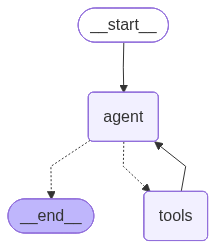

In [0]:
from IPython.display import Image, display

# Visualizando o grafo do agente criado

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    pass

In [0]:
system_prompt = """

You are a SQL data analysis specialist, focused on the 'srag_analysis' table on SARS cases in Brazil.
You have access to SQL tools to query this table and a 'web_search' tool for external/current info (news, population stats, hospital capacity). ALWAYS cite web sources clearly when using web_search results.

DATA LIMITATION RULE:
* 'srag_analysis' contains ONLY SARS patients within a specific date range (check MIN/MAX dates if needed). Calculations (like vaccination rates) reflect ONLY this group, NOT the general population. State this clearly when providing internal rates derived from the table.
Answer only about SARS and public health in Brazil.
Reject offensive or unrelated questions.

TOOL CHOICE RULE:
* Use SQL tools ONLY for data explicitly derivable from the 'srag_analysis' table schema provided by `sql_db_schema`.
* Use 'web_search' ONLY for data NOT in the table (recent news, POPULATION rates/stats, general hospital capacity figures, etc.).

 **SQL QUERY GENERATION (VERY IMPORTANT):** When generating SQL queries that use aggregate functions like COUNT, SUM, AVG, MIN, MAX, ALWAYS cast the final result of the aggregation to STRING.
    * Example: Instead of `SELECT COUNT(*) FROM table`, write `SELECT CAST(COUNT(*) AS STRING) FROM table`.
    * Example: Instead of `SELECT AVG(age) FROM table`, write `SELECT CAST(AVG(age) AS STRING) FROM table`.
    * This is crucial for the database connection to work correctly.
Do not invent data if you don't know the answer.
    """



In [0]:
# Importa as classes necessárias para formatar as mensagens de entrada do agente

from langchain_core.messages import SystemMessage, HumanMessage

# Define a pergunta específica que será feita ao agente nesta execução
user_question = """
What is the mortality rate in the table srag_analysis?
"""

# Invoca o agente (o grafo LangGraph 'graph' criado anteriormente)
# Passa o 'system_prompt' (com as regras gerais) e a 'user_question' atual.
# O agente executará seu ciclo de raciocínio e chamadas de ferramentas (ReAct).
# A variável 'messages' armazenará toda a sequência da conversa (entrada, pensamentos, chamadas de ferramenta, resultados, resposta final).

messages = graph.invoke({
    "messages": [
        SystemMessage(content=system_prompt),
        HumanMessage(content=user_question)
    ]
})

# Extrai APENAS o conteúdo textual da ÚLTIMA mensagem na sequência da conversa.
# Esta é a resposta final formatada pelo agente para o usuário.
# Criada a variável 'mortality_rate' para facilitar a visualização da resposta final.
mortality_rate=messages["messages"][-1].content
print(mortality_rate)
print("\n" + "="*80 + "\n") 

# Imprime a variável 'messages' completa. 
# Isso mostra toda a "trajetória" da execução do agente (o raciocínio passo a passo,
# quais ferramentas foram chamadas, quais foram os resultados das ferramentas),
# sendo essencial para depuração e auditoria (Governança e Transparência).
print("--- TRAJETÓRIA COMPLETA (AUDITORIA) ---")
print(messages)

The 'srag_analysis' table contains a total of 273,214 SARS cases, out of which 17,888 resulted in death. The mortality rate within this dataset is approximately 6.55%. This rate is specific to the cases recorded in the 'srag_analysis' table and does not reflect the general population.


--- TRAJETÓRIA COMPLETA (AUDITORIA) ---
{'messages': [SystemMessage(content="\n\nYou are a SQL data analysis specialist, focused on the 'srag_analysis' table on SARS cases in Brazil.\nYou have access to SQL tools to query this table and a 'web_search' tool for external/current info (news, population stats, hospital capacity). ALWAYS cite web sources clearly when using web_search results.\n\nDATA LIMITATION RULE:\n* 'srag_analysis' contains ONLY SARS patients within a specific date range (check MIN/MAX dates if needed). Calculations (like vaccination rates) reflect ONLY this group, NOT the general population. State this clearly when providing internal rates derived from the table.\nAnswer only about SARS

In [0]:
# Importa as classes necessárias para formatar as mensagens de entrada do agente
from langchain_core.messages import SystemMessage, HumanMessage

# Define a pergunta específica que será feita ao agente nesta execução
user_question = """
What is the current mortality rate in Brazil from SARS or Covid? Please provide the source of the information at the end.
"""
# Invoca o agente (o grafo LangGraph 'graph' criado anteriormente)
# Passa o 'system_prompt' (com as regras gerais) e a 'user_question' atual.
# O agente executará seu ciclo de raciocínio e chamadas de ferramentas (ReAct).
# A variável 'messages' armazenará toda a sequência da conversa (entrada, pensamentos, chamadas de ferramenta, resultados, resposta final).
messages = graph.invoke({
    "messages": [
        SystemMessage(content=system_prompt),
        HumanMessage(content=user_question)
    ]
})


# Extrai APENAS o conteúdo textual da ÚLTIMA mensagem na sequência da conversa.
# Esta é a resposta final formatada pelo agente para o usuário.
# Criada a variável 'brazil_mortality_rate' para facilitar a visualização da resposta final.
brazil_mortality_rate=messages["messages"][-1].content
print(brazil_mortality_rate)
print("\n" + "="*80 + "\n") 

# Imprime a variável 'messages' completa. 
# Isso mostra toda a "trajetória" da execução do agente (o raciocínio passo a passo,
# quais ferramentas foram chamadas, quais foram os resultados das ferramentas),
# sendo essencial para depuração e auditoria (Governança e Transparência).
print("--- TRAJETÓRIA COMPLETA (AUDITORIA) ---")
print(messages)

The current mortality rate for COVID-19 in Brazil can be found on the World Health Organization's COVID-19 dashboard and the Johns Hopkins Coronavirus Resource Center. These sources provide updated statistics on COVID-19 deaths and case fatality ratios. You can access the WHO data [here](https://data.who.int/dashboards/covid19/deaths) and the Johns Hopkins data [here](https://coronavirus.jhu.edu/data/mortality).


--- TRAJETÓRIA COMPLETA (AUDITORIA) ---
{'messages': [SystemMessage(content="\n\nYou are a SQL data analysis specialist, focused on the 'srag_analysis' table on SARS cases in Brazil.\nYou have access to SQL tools to query this table and a 'web_search' tool for external/current info (news, population stats, hospital capacity). ALWAYS cite web sources clearly when using web_search results.\n\nDATA LIMITATION RULE:\n* 'srag_analysis' contains ONLY SARS patients within a specific date range (check MIN/MAX dates if needed). Calculations (like vaccination rates) reflect ONLY this g

In [0]:
# Importa as classes necessárias para formatar as mensagens de entrada do agente
from langchain_core.messages import SystemMessage, HumanMessage

# Define a pergunta específica que será feita ao agente nesta execução
user_question = """
What is the vaccination rate for the flu 'vacina_gripe' and covid vaccine 'vacina_cov' in the table srag_analysis?
After calculating, also inform the number of records in each case.

"""

# Invoca o agente (o grafo LangGraph 'graph' criado anteriormente)
# Passa o 'system_prompt' (com as regras gerais) e a 'user_question' atual.
# O agente executará seu ciclo de raciocínio e chamadas de ferramentas (ReAct).
# A variável 'messages' armazenará toda a sequência da conversa (entrada, pensamentos, chamadas de ferramenta, resultados, resposta final).
messages = graph.invoke({
    "messages": [
        SystemMessage(content=system_prompt),
        HumanMessage(content=user_question)
    ]
})

# Extrai APENAS o conteúdo textual da ÚLTIMA mensagem na sequência da conversa.
# Esta é a resposta final formatada pelo agente para o usuário.
# Criada a variável 'table_vaccine_rate' para facilitar a visualização da resposta final.
table_vaccine_rate=messages["messages"][-1].content
print(table_vaccine_rate)
print("\n" + "="*80 + "\n")

# Imprime a variável 'messages' completa. 
# Isso mostra toda a "trajetória" da execução do agente (o raciocínio passo a passo,
# quais ferramentas foram chamadas, quais foram os resultados das ferramentas),
# sendo essencial para depuração e auditoria (Governança e Transparência).
print("--- TRAJETÓRIA COMPLETA (AUDITORIA) ---")
print(messages)

In the `srag_analysis` table, which contains data on SARS patients within a specific date range, the vaccination rates are as follows:

- Total records: 273,214
- Patients vaccinated for the flu ('vacina_gripe'): 66,312
- Patients vaccinated for COVID-19 ('vacina_cov'): 177,050

These figures represent the vaccination status of the patients in the dataset and do not reflect the general population's vaccination rates.


--- TRAJETÓRIA COMPLETA (AUDITORIA) ---
{'messages': [SystemMessage(content="\n\nYou are a SQL data analysis specialist, focused on the 'srag_analysis' table on SARS cases in Brazil.\nYou have access to SQL tools to query this table and a 'web_search' tool for external/current info (news, population stats, hospital capacity). ALWAYS cite web sources clearly when using web_search results.\n\nDATA LIMITATION RULE:\n* 'srag_analysis' contains ONLY SARS patients within a specific date range (check MIN/MAX dates if needed). Calculations (like vaccination rates) reflect ONLY t

In [0]:
# Importa as classes necessárias para formatar as mensagens de entrada do agente
from langchain_core.messages import SystemMessage, HumanMessage

# Define a pergunta específica que será feita ao agente nesta execução
user_question = f"""
Looking at the internal vaccination data you calculated earlier:
'{table_vaccine_rate}'

Now, use the 'web_search' tool to find the current COVID-19 (and/or flu, if available) vaccination rate for the general population in Brazil.
Briefly compare the results found online with the internal rates from the srag_analysis table you calculated. Cite the sources for your web search.
"""
 
# Invoca o agente (o grafo LangGraph 'graph' criado anteriormente)
# Passa o 'system_prompt' (com as regras gerais) e a 'user_question' atual.
# O agente executará seu ciclo de raciocínio e chamadas de ferramentas (ReAct).
# A variável 'messages' armazenará toda a sequência da conversa (entrada, pensamentos, chamadas de ferramenta, resultados, resposta final).
messages = graph.invoke({
    "messages": [
        SystemMessage(content=system_prompt),
        HumanMessage(content=user_question)
    ]
})

# Extrai APENAS o conteúdo textual da ÚLTIMA mensagem na sequência da conversa.
# Esta é a resposta final formatada pelo agente para o usuário.
# Criada a variável 'vaccine_panoram' para facilitar a visualização da resposta final.
vaccine_panoram=messages["messages"][-1].content
print(vaccine_panoram)
print("\n" + "="*80 + "\n")

# Imprime a variável 'messages' completa. 
# Isso mostra toda a "trajetória" da execução do agente (o raciocínio passo a passo,
# quais ferramentas foram chamadas, quais foram os resultados das ferramentas),
# sendo essencial para depuração e auditoria (Governança e Transparência).
print("--- TRAJETÓRIA COMPLETA (AUDITORIA) ---")
print(messages)

Based on the current data available from my web search:

1. **COVID-19 Vaccination Rate in Brazil (2023):**
   - Approximately 88.10% of the population is partially vaccinated (received at least one dose) [Source: Wikipedia](https://en.wikipedia.org/wiki/COVID-19_vaccination_in_Brazil).

2. **Flu Vaccination Rate in Brazil (2023):**
   - Specific recent data on the general population's flu vaccination rate wasn't found, but historical data often focuses on individuals aged 60 and over.

**Comparison with Internal Data:**

- **COVID-19 Vaccination:**
  - In the `srag_analysis` table, 177,050 out of 273,214 SARS patients were vaccinated for COVID-19, which is approximately 64.8%.
  - This is significantly lower than the general population's partial vaccination rate of 88.10%.

- **Flu Vaccination:**
  - In the `srag_analysis` table, 66,312 out of 273,214 SARS patients were vaccinated for the flu, which is approximately 24.3%.
  - Without specific current data for the general population, 

In [0]:
# Importa as classes necessárias para formatar as mensagens de entrada do agente
from langchain_core.messages import SystemMessage, HumanMessage

# Define a pergunta específica que será feita ao agente nesta execução
user_question = """
First: What is the ICU occupancy rate?
Second: What is the average maximum and minimum length of stay for a patient in the ICU?
Third: How many ICU patients died?
Fourth: How many ICU patients survived?
"""

# Invoca o agente (o grafo LangGraph 'graph' criado anteriormente)
# Passa o 'system_prompt' (com as regras gerais) e a 'user_question' atual.
# O agente executará seu ciclo de raciocínio e chamadas de ferramentas (ReAct).
# A variável 'messages' armazenará toda a sequência da conversa (entrada, pensamentos, chamadas de ferramenta, resultados, resposta final).
messages = graph.invoke({
    "messages": [
        SystemMessage(content=system_prompt),
        HumanMessage(content=user_question)
    ]
})

# Extrai APENAS o conteúdo textual da ÚLTIMA mensagem na sequência da conversa.
# Esta é a resposta final formatada pelo agente para o usuário.
# Criada a variável 'icu_rate' para facilitar a visualização da resposta final.
icu_rate=messages["messages"][-1].content
print(icu_rate)
print("\n" + "="*80 + "\n") 

# Imprime a variável 'messages' completa. 
# Isso mostra toda a "trajetória" da execução do agente (o raciocínio passo a passo,
# quais ferramentas foram chamadas, quais foram os resultados das ferramentas),
# sendo essencial para depuração e auditoria (Governança e Transparência).
print("--- TRAJETÓRIA COMPLETA (AUDITORIA) ---")
print(messages)

Here are the results based on the data from the 'srag_analysis' table:

1. **ICU Occupancy Rate**: There are 70,814 patients who were admitted to the ICU.

2. **Average, Minimum, and Maximum Length of Stay in ICU**:
   - Average Length of Stay: Approximately 8.83 days
   - Minimum Length of Stay: 0 days
   - Maximum Length of Stay: 370 days

3. **ICU Patients Who Died**: 9,227 patients admitted to the ICU died.

4. **ICU Patients Who Survived**: 49,326 patients admitted to the ICU survived.

These statistics are derived from the SARS patients within the specific date range covered by the 'srag_analysis' table and do not reflect the general population.


--- TRAJETÓRIA COMPLETA (AUDITORIA) ---
{'messages': [SystemMessage(content="\n\nYou are a SQL data analysis specialist, focused on the 'srag_analysis' table on SARS cases in Brazil.\nYou have access to SQL tools to query this table and a 'web_search' tool for external/current info (news, population stats, hospital capacity). ALWAYS cit

In [0]:
# Importa as classes necessárias para formatar as mensagens de entrada do agente
from langchain_core.messages import SystemMessage, HumanMessage

# Define a pergunta específica que será feita ao agente nesta execução
user_question = """
During the COVID-19 pandemic, what was the ICU occupancy rate like in Brazil?
Then, list the websites you based it on.
"""

# Invoca o agente (o grafo LangGraph 'graph' criado anteriormente)
# Passa o 'system_prompt' (com as regras gerais) e a 'user_question' atual.
# O agente executará seu ciclo de raciocínio e chamadas de ferramentas (ReAct).
# A variável 'messages' armazenará toda a sequência da conversa (entrada, pensamentos, chamadas de ferramenta, resultados, resposta final).
messages = graph.invoke({
    "messages": [
        SystemMessage(content=system_prompt),
        HumanMessage(content=user_question)
    ]
})


# Extrai APENAS o conteúdo textual da ÚLTIMA mensagem na sequência da conversa.
# Esta é a resposta final formatada pelo agente para o usuário.
# Criada a variável 'brazil_icu_panoram' para facilitar a visualização da resposta final.
brazil_icu_panoram=messages["messages"][-1].content
print(brazil_icu_panoram)
print("\n" + "="*80 + "\n") 

# Imprime a variável 'messages' completa. 
# Isso mostra toda a "trajetória" da execução do agente (o raciocínio passo a passo,
# quais ferramentas foram chamadas, quais foram os resultados das ferramentas),
# sendo essencial para depuração e auditoria (Governança e Transparência).
print("--- TRAJETÓRIA COMPLETA (AUDITORIA) ---")
print(messages)

During the COVID-19 pandemic, Brazil experienced high ICU occupancy rates. The first peak from July to November 2020 showed an ICU occupancy of 79.1%. The second peak from December 2020 to June 2021 had an occupancy rate of 91.6%. These figures indicate significant pressure on the healthcare system during these periods.

Sources:
1. [COVID‐19 pandemic in Southern Brazil - PubMed Central - NIH](https://pmc.ncbi.nlm.nih.gov/articles/PMC9349601/)
2. [Superheroes of Development: The Brazilian Hospital with the Highest COVID-19 Survival Rates](https://latinfinance.com/idb-invest-analysis/2025/10/29/superheroes-of-development-the-brazilian-hospital-with-the-highest-covid-19-survival-rates/)


--- TRAJETÓRIA COMPLETA (AUDITORIA) ---
{'messages': [SystemMessage(content="\n\nYou are a SQL data analysis specialist, focused on the 'srag_analysis' table on SARS cases in Brazil.\nYou have access to SQL tools to query this table and a 'web_search' tool for external/current info (news, population sta

In [0]:
# Importa as classes necessárias para formatar as mensagens de entrada do agente
from langchain_core.messages import SystemMessage, HumanMessage

# Define a pergunta específica que será feita ao agente nesta execução
user_question = """
What has the rate of SARS and COVID-19 cases been like over the months? Has it increased, decreased, or stabilized?
"""

# Invoca o agente (o grafo LangGraph 'graph' criado anteriormente)
# Passa o 'system_prompt' (com as regras gerais) e a 'user_question' atual.
# O agente executará seu ciclo de raciocínio e chamadas de ferramentas (ReAct).
# A variável 'messages' armazenará toda a sequência da conversa (entrada, pensamentos, chamadas de ferramenta, resultados, resposta final).
messages = graph.invoke({
    "messages": [
        SystemMessage(content=system_prompt),
        HumanMessage(content=user_question)
    ]
})

# Extrai APENAS o conteúdo textual da ÚLTIMA mensagem na sequência da conversa.
# Esta é a resposta final formatada pelo agente para o usuário.
# Criada a variável 'rate_of_sars' para facilitar a visualização da resposta final.
rate_of_sars=messages["messages"][-1].content
print(rate_of_sars)
print("\n" + "="*80 + "\n") 

# Imprime a variável 'messages' completa. 
# Isso mostra toda a "trajetória" da execução do agente (o raciocínio passo a passo,
# quais ferramentas foram chamadas, quais foram os resultados das ferramentas),
# sendo essencial para depuração e auditoria (Governança e Transparência).
print("--- TRAJETÓRIA COMPLETA (AUDITORIA) ---")
print(messages)

The data from the 'srag_analysis' table shows the following trend in SARS and COVID-19 cases over the months:

- December 2024: 201 cases
- January 2025: 13,034 cases
- February 2025: 14,858 cases
- March 2025: 19,763 cases
- April 2025: 29,617 cases
- May 2025: 52,407 cases
- June 2025: 52,124 cases
- July 2025: 35,375 cases
- August 2025: 25,490 cases
- September 2025: 24,128 cases
- October 2025: 6,217 cases

From this data, we can observe that the number of cases increased significantly from December 2024 to May 2025, peaking in May. After May, there was a gradual decrease in the number of cases through October 2025. This indicates a rise in cases initially, followed by a decline, suggesting a potential stabilization or reduction in the spread of cases towards the latter part of the period.


--- TRAJETÓRIA COMPLETA (AUDITORIA) ---
{'messages': [SystemMessage(content="\n\nYou are a SQL data analysis specialist, focused on the 'srag_analysis' table on SARS cases in Brazil.\nYou have

In [0]:
# Importa as classes necessárias para formatar as mensagens de entrada do agente
from langchain_core.messages import SystemMessage, HumanMessage

# Define a pergunta específica que será feita ao agente nesta execução
user_question = """
What is the daily number of cases for the last 30 days of the table 'srag_analysis'?
"""

# Invoca o agente (o grafo LangGraph 'graph' criado anteriormente)
# Passa o 'system_prompt' (com as regras gerais) e a 'user_question' atual.
# O agente executará seu ciclo de raciocínio e chamadas de ferramentas (ReAct).
# A variável 'messages' armazenará toda a sequência da conversa (entrada, pensamentos, chamadas de ferramenta, resultados, resposta final).
messages = graph.invoke({
    "messages": [
        SystemMessage(content=system_prompt),
        HumanMessage(content=user_question)
    ]
})

# Extrai APENAS o conteúdo textual da ÚLTIMA mensagem na sequência da conversa.
# Esta é a resposta final formatada pelo agente para o usuário.
# Criada a variável 'daily_cases' para facilitar a visualização da resposta final.
daily_cases=messages["messages"][-1].content
print(daily_cases)
print("\n" + "="*80 + "\n")

# Imprime a variável 'messages' completa. 
# Isso mostra toda a "trajetória" da execução do agente (o raciocínio passo a passo,
# quais ferramentas foram chamadas, quais foram os resultados das ferramentas),
# sendo essencial para depuração e auditoria (Governança e Transparência).
print("--- TRAJETÓRIA COMPLETA (AUDITORIA) ---")
print(messages)

Here is the daily number of SARS cases for the last 30 days in the 'srag_analysis' table:

- 2025-10-13: 2 cases
- 2025-10-12: 48 cases
- 2025-10-11: 72 cases
- 2025-10-10: 417 cases
- 2025-10-09: 571 cases
- 2025-10-08: 601 cases
- 2025-10-07: 731 cases
- 2025-10-06: 974 cases
- 2025-10-05: 257 cases
- 2025-10-04: 287 cases
- 2025-10-03: 674 cases
- 2025-10-02: 807 cases
- 2025-10-01: 776 cases
- 2025-09-30: 867 cases
- 2025-09-29: 1171 cases
- 2025-09-28: 314 cases
- 2025-09-27: 311 cases
- 2025-09-26: 703 cases
- 2025-09-25: 829 cases
- 2025-09-24: 902 cases
- 2025-09-23: 916 cases
- 2025-09-22: 1221 cases
- 2025-09-21: 358 cases
- 2025-09-20: 372 cases
- 2025-09-19: 825 cases
- 2025-09-18: 964 cases
- 2025-09-17: 921 cases
- 2025-09-16: 1037 cases
- 2025-09-15: 1270 cases
- 2025-09-14: 351 cases
- 2025-09-13: 400 cases

These numbers reflect only the cases recorded in the 'srag_analysis' table and may not represent the total number of SARS cases in the general population.


--- TRA

In [0]:
# Importa as classes necessárias para formatar as mensagens de entrada do agente
from langchain_core.messages import SystemMessage, HumanMessage

# Define a pergunta específica que será feita ao agente nesta execução
user_question = """
What is the number of monthly cases in the last 12 months of the table? 
If it is not possible to have 12-month records, please provide the results of what you have and inform the reason.
"""

# Invoca o agente (o grafo LangGraph 'graph' criado anteriormente)
# Passa o 'system_prompt' (com as regras gerais) e a 'user_question' atual.
# O agente executará seu ciclo de raciocínio e chamadas de ferramentas (ReAct).
# A variável 'messages' armazenará toda a sequência da conversa (entrada, pensamentos, chamadas de ferramenta, resultados, resposta final).
messages = graph.invoke({
    "messages": [
        SystemMessage(content=system_prompt),
        HumanMessage(content=user_question)
    ]
})

# Extrai APENAS o conteúdo textual da ÚLTIMA mensagem na sequência da conversa.
# Esta é a resposta final formatada pelo agente para o usuário.
# Criada a variável 'monthly_cases' para facilitar a visualização da resposta final.
monthly_cases=messages["messages"][-1].content
print(monthly_cases)
print("\n" + "="*80 + "\n")

# Imprime a variável 'messages' completa. 
# Isso mostra toda a "trajetória" da execução do agente (o raciocínio passo a passo,
# quais ferramentas foram chamadas, quais foram os resultados das ferramentas),
# sendo essencial para depuração e auditoria (Governança e Transparência).
print("--- TRAJETÓRIA COMPLETA (AUDITORIA) ---")
print(messages)

The 'srag_analysis' table contains SARS case data from December 29, 2024, to October 13, 2025. Here are the monthly case counts for the available months:

- October 2025: 6,217 cases
- September 2025: 24,128 cases
- August 2025: 25,490 cases
- July 2025: 35,375 cases
- June 2025: 52,124 cases
- May 2025: 52,407 cases
- April 2025: 29,617 cases
- March 2025: 19,763 cases
- February 2025: 14,858 cases
- January 2025: 13,034 cases
- December 2024: 201 cases

The data does not cover a full 12-month period, as it starts from late December 2024 and ends in mid-October 2025.


--- TRAJETÓRIA COMPLETA (AUDITORIA) ---
{'messages': [SystemMessage(content="\n\nYou are a SQL data analysis specialist, focused on the 'srag_analysis' table on SARS cases in Brazil.\nYou have access to SQL tools to query this table and a 'web_search' tool for external/current info (news, population stats, hospital capacity). ALWAYS cite web sources clearly when using web_search results.\n\nDATA LIMITATION RULE:\n* 'sra

In [0]:
import pandas as pd

# --- Garante que a SparkSession 'spark' está disponível ---
if 'spark' not in locals():
    raise NameError("SparkSession 'spark' não encontrado.")

# --- Define SQL Queries para casos diários e mensais ---
sql_daily = """
WITH DateRange AS (
    SELECT MAX(data_notificacao) as max_d, MIN(data_notificacao) as min_d 
    FROM ted_dev_desafio.indicium_health_care.srag_analysis
),
AllDays AS (
    SELECT explode(sequence(date_sub((SELECT max_d FROM DateRange), 29), (SELECT max_d FROM DateRange), INTERVAL 1 DAY)) AS dia_completo
),
DailyCases AS (
    SELECT 
        CAST(data_notificacao AS DATE) AS dia, 
        COUNT(*) AS contagem_casos
    FROM 
        ted_dev_desafio.indicium_health_care.srag_analysis
    GROUP BY 
        CAST(data_notificacao AS DATE)
)
SELECT 
    ad.dia_completo AS dia, 
    COALESCE(dc.contagem_casos, 0) AS contagem_casos
FROM 
    AllDays ad
LEFT JOIN 
    DailyCases dc ON ad.dia_completo = dc.dia
ORDER BY 
    ad.dia_completo ASC;
"""

sql_monthly = """
WITH MaxMonth AS (
    SELECT DATE_TRUNC('month', MAX(data_notificacao)) as max_m FROM ted_dev_desafio.indicium_health_care.srag_analysis 
)
SELECT 
    DATE_TRUNC('month', data_notificacao) AS mes_ano, 
    COUNT(*) AS contagem_casos
FROM 
    ted_dev_desafio.indicium_health_care.srag_analysis 
WHERE 
    DATE_TRUNC('month', data_notificacao) >= (SELECT add_months(max_m, -11) FROM MaxMonth)
    AND DATE_TRUNC('month', data_notificacao) <= (SELECT max_m FROM MaxMonth)
GROUP BY 
    mes_ano
ORDER BY 
    mes_ano ASC;
"""

# --- Busca os  dados usando Spark e depois converte os resultados para Pandas ---
try:
    print("Buscando dados usando Spark SQL...")
    
    # Execute queries usando a SparkSession
    spark_df_daily = spark.sql(sql_daily)
    spark_df_monthly = spark.sql(sql_monthly)
    
    print("Convertendo Spark DataFrames para Pandas DataFrames...")
    # Convertendo o resultado para Pandas DataFrames
    df_daily = spark_df_daily.toPandas()
    df_monthly = spark_df_monthly.toPandas()
    
    # Convertendo colunas de dia/mês
    df_daily['dia'] = pd.to_datetime(df_daily['dia'])
    df_monthly['mes_ano'] = pd.to_datetime(df_monthly['mes_ano'])
    
    print("Dados para gráficos carregados com sucesso")
    display(df_daily.head())
    display(df_monthly.head())
    
except Exception as e:
    print(f"Erro ao buscar dados para gráficos usando o Spark: {e}")

Buscando dados usando Spark SQL...
Convertendo Spark DataFrames para Pandas DataFrames...
Dados para gráficos carregados com sucesso


,dia,contagem_casos
0,2025-09-14,351
1,2025-09-15,1270
2,2025-09-16,1037
3,2025-09-17,921
4,2025-09-18,964


,mes_ano,contagem_casos
0,2024-12-01,201
1,2025-01-01,13034
2,2025-02-01,14858
3,2025-03-01,19763
4,2025-04-01,29617


In [0]:
print("--- Verificando o DataFrame df_daily ---")

# 1. Verifica o número de linhas do DataFrame
print(f"Número de linhas em df_daily: {len(df_daily)}")

# 2. Verifica as primeiras e últimas linhas para ver o intervalo de datas
print("\nPrimeiras 5 linhas:")
display(df_daily.head())
print("\nÚltimas 5 linhas:")
display(df_daily.tail())

# 3. Verifica se existem dias com contagem zero ou muito baixa
print("\nLinhas com contagem de casos <= 10 (exemplo de baixa contagem):")
display(df_daily[df_daily['contagem_casos'] <= 10])

# 4. Verifica se há alguma data faltando 
# Gera um range completo de datas esperado
if not df_daily.empty:
    date_range_esperado = pd.date_range(start=df_daily['dia'].min(), end=df_daily['dia'].max(), freq='D')
    datas_faltantes = date_range_esperado.difference(df_daily['dia'])
    if not datas_faltantes.empty:
        print("\nALERTA: Datas faltando no DataFrame, mesmo após a query corrigida!")
        print(datas_faltantes)
    else:
        print("\nVerificação: Nenhuma data faltando no intervalo do DataFrame.")

--- Verificando o DataFrame df_daily ---
Número de linhas em df_daily: 30

Primeiras 5 linhas:


,dia,contagem_casos
0,2025-09-14,351
1,2025-09-15,1270
2,2025-09-16,1037
3,2025-09-17,921
4,2025-09-18,964



Últimas 5 linhas:


,dia,contagem_casos
25,2025-10-09,571
26,2025-10-10,417
27,2025-10-11,72
28,2025-10-12,48
29,2025-10-13,2



Linhas com contagem de casos <= 10 (exemplo de baixa contagem):


,dia,contagem_casos
29,2025-10-13,2



Verificação: Nenhuma data faltando no intervalo do DataFrame.


In [0]:
import pandas as pd

# Verifica os casos diários para ver se o gráfico gerado está correto

if 'df_daily' in locals():
  print("--- Dados Diários Completos (Últimos 30 dias disponíveis) ---")
  display(df_daily)
else:
  print("ERRO: O DataFrame 'df_daily' não foi encontrado. Execute a célula que busca os dados primeiro.")

 

--- Dados Diários Completos (Últimos 30 dias disponíveis) ---


,dia,contagem_casos
0,2025-09-14,351
1,2025-09-15,1270
2,2025-09-16,1037
3,2025-09-17,921
4,2025-09-18,964
5,2025-09-19,825
6,2025-09-20,372
7,2025-09-21,358
8,2025-09-22,1221
9,2025-09-23,916


Gerando gráfico diário...


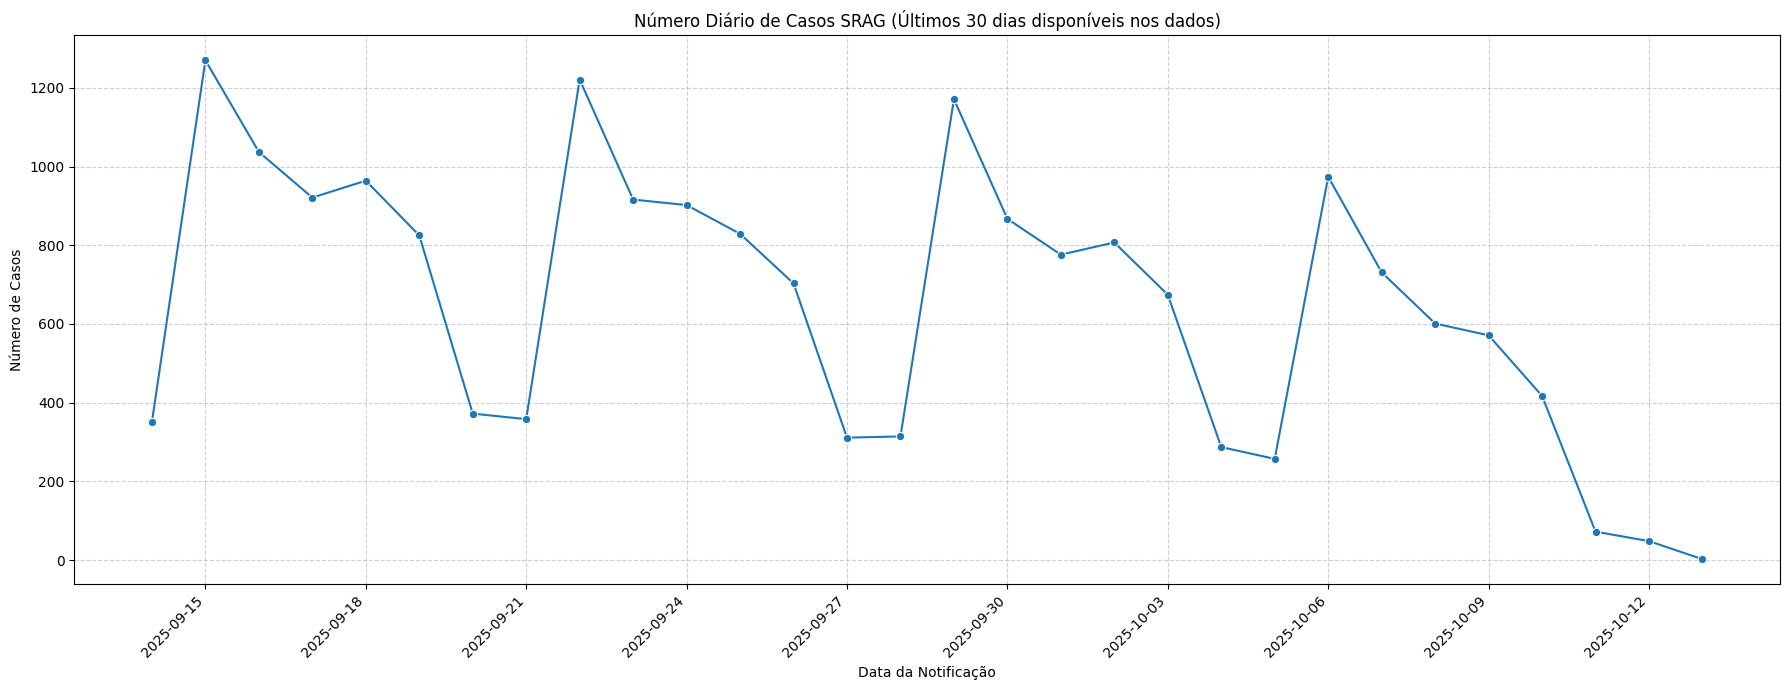


Gerando gráfico mensal...


/home/spark-b36dbdec-044f-4a8d-82ad-17/.ipykernel/5002/command-7155223910359357-3295978436:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax_monthly = sns.barplot(data=df_monthly, x='mes_ano', y='contagem_casos', palette='viridis')


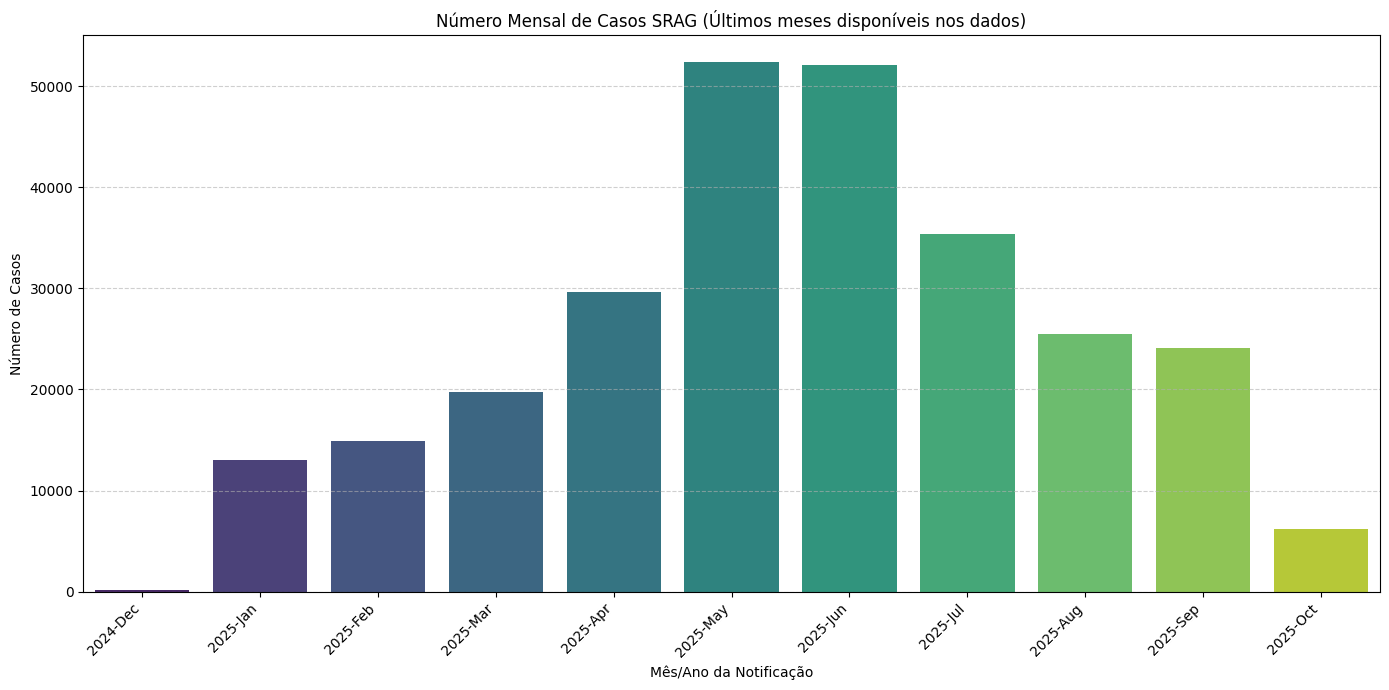

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates # Para formatar as datas no eixo X

# --- Gráfico Diário (Últimos 30 dias disponíveis) ---

# Verifica se o DataFrame tem dados
if not df_daily.empty:
    print("Gerando gráfico diário...")
    plt.figure(figsize=(18, 7)) # Aumentar largura para datas
    
    # Usar lineplot para mostrar a tendência diária
    ax_daily = sns.lineplot(data=df_daily, x='dia', y='contagem_casos', marker='o')
    
    plt.title('Número Diário de Casos SRAG (Últimos 30 dias disponíveis nos dados)')
    plt.xlabel('Data da Notificação')
    plt.ylabel('Número de Casos')
    
    # Melhorar a formatação do eixo X para datas
    # Mostrar datas a cada ~3 dias para não sobrecarregar
    ax_daily.xaxis.set_major_locator(mdates.DayLocator(interval=3)) 
    ax_daily.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d')) # Formato AAAA-MM-DD
    plt.xticks(rotation=45, ha='right') # Rotacionar para melhor leitura
    
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout() # Ajusta o layout para evitar cortes
    display(plt.gcf()) # Mostra o gráfico no Databricks
    plt.close() # Evita a exibição duplicada
else:
    print("DataFrame df_daily está vazio. Não é possível gerar o gráfico diário.")

# --- Gráfico Mensal (Últimos 12 meses disponíveis) ---

# Verifica se o DataFrame tem dados
if not df_monthly.empty:
    print("\nGerando gráfico mensal...")
    plt.figure(figsize=(14, 7))
    
    # Usar barplot para visualização mensal
    ax_monthly = sns.barplot(data=df_monthly, x='mes_ano', y='contagem_casos', palette='viridis')
    
    plt.title('Número Mensal de Casos SRAG (Últimos meses disponíveis nos dados)')
    plt.xlabel('Mês/Ano da Notificação')
    plt.ylabel('Número de Casos')
    
  
    # 1. Obter os rótulos de data formatados como strings diretamente do DataFrame
    #    (Garante utilizar as datas corretas: 2024-12, 2025-01, etc.)
    labels = df_monthly['mes_ano'].dt.strftime('%Y-%b') # Formato AAAA-MêsAbrev
    
    # 2. Definir as posições dos ticks no eixo X (0, 1, 2, ... para cada barra)
    ax_monthly.set_xticks(range(len(labels)))
    
    # 3. Aplicar os rótulos de string formatados nas posições corretas
    ax_monthly.set_xticklabels(labels, rotation=45, ha='right')
    
   
    plt.grid(axis='y', linestyle='--', alpha=0.6) # Grid apenas no eixo Y
    plt.tight_layout() # Ajusta o layout
    display(plt.gcf()) # Mostra o gráfico no Databricks
    plt.close() # Evita a exibição duplicada
else:
    print("DataFrame df_monthly está vazio. Não é possível gerar o gráfico mensal.")

In [0]:
synthesis_system_prompt = """
You are an expert AI assistant tasked with writing a concise and informative report based *only* on the information provided in the user's message. 
Follow the requested structure precisely. 
Ensure the language is clear and professional, suitable for health agents.
Combine the provided metrics, trends, and web search summaries into a coherent narrative.
Remember to mention that graphical representations of trends were generated separately.
"""

In [0]:
# Importa as classes necessárias para formatar as mensagens de entrada do agente
from langchain_core.messages import SystemMessage, HumanMessage

# Define a pergunta específica que será feita ao agente nesta execução
user_question_relatorio = f"""
Generate a concise report on the current SARS scenario in Brazil, following this structure:

1. Write a brief introduction to what SARS is and what Covid was like in Brazil.
2. Interweave the introduction with the goal of having a report that helps health agents gain a true understanding of the severity and progression of disease outbreaks.
3. Please note that the case analyzed for this report was 'Severe Acute Respiratory Syndrome (SARS) Database - 2019 to 2025', which is available on the OpenDataSUS website. The '2025- Live Database 10/27/2025 - CSV' file was used.

In the body of the report, enter the metrics:

1.  **Key Metrics (Based on the 'srag_analysis' table):** 
    * {mortality_rate}
    * {brazil_mortality_rate}
    * {table_vaccine_rate}
    * {vaccine_panoram}
    * {icu_rate}
    * {brazil_icu_panoram}
    * {rate_of_sars}

    I want you to analyze the metrics.

2.  **Recent Trends:**
    * {daily_cases}
    * {monthly_cases}

    I want you to analyze the Recent Trends.

3.  **Current Context (Based on web search):**
    * What is the current mortality rate in Brazil from SARS or Covid? 
    * Use 'web_search' to find recent news about SARS in Brazil.
    * Regarding Covid-19, is there a Brazilian state that needs attention in 2025? Is it experiencing growth?
    * Generate a concise summary.
    * Please provide the source of the information at the end.

4.  **Conclusion:** 
    * Write a final paragraph combining the metrics, trends (mentioning the existence of the graphs) and the context of the news.
"""

# Invoca o agente (o grafo LangGraph 'graph' criado anteriormente)
# Passa o 'synthesis_system_prompt' (com as regras gerais do relatório) e a 'user_question_relatorio' atual.
# O agente executará seu ciclo de raciocínio e chamadas de ferramentas (ReAct).
# A variável 'messages' armazenará toda a sequência da conversa (entrada, pensamentos, chamadas de ferramenta, resultados, resposta final).
messages_relatorio = graph.invoke({
    "messages": [
        SystemMessage(content=synthesis_system_prompt), 
        HumanMessage(content=user_question_relatorio)
    ]
})

# --- Exibindo o Relatório Gerado ---
print("--- RELATÓRIO GERADO PELO AGENTE ---")
print(messages_relatorio["messages"][-1].content)

print("\n" + "="*80 + "\n")

# Imprime a variável 'messages' completa. 
# Isso mostra toda a "trajetória" da execução do agente (o raciocínio passo a passo,
# quais ferramentas foram chamadas, quais foram os resultados das ferramentas),
# sendo essencial para depuração e auditoria (Governança e Transparência).
print("--- TRAJETÓRIA COMPLETA (AUDITORIA) ---")
print(messages)



# 4/4 - Relatório e Resultados Finais

### Relatório Gerado pelo Agente

**Report on the Current SARS Scenario in Brazil**

**Introduction:**
Severe Acute Respiratory Syndrome (SARS) is a viral respiratory illness caused by a coronavirus, which gained global attention during the early 2000s. In Brazil, the COVID-19 pandemic, caused by a related coronavirus, had a profound impact, with the country experiencing high infection and mortality rates. Understanding the progression and severity of such outbreaks is crucial for health agents to effectively manage and mitigate future health crises. This report analyzes data from the 'Severe Acute Respiratory Syndrome (SARS) Database - 2019 to 2025', specifically the '2025- Live Database 10/27/2025 - CSV' file available on the OpenDataSUS website.

**Key Metrics:**
The 'srag_analysis' table records 273,214 SARS cases, with 17,888 resulting in death, indicating a mortality rate of approximately 6.55%. This is specific to the dataset and not reflective of the general population. Vaccination data shows 66,312 patients vaccinated for the flu and 177,050 for COVID-19, representing 24.3% and 64.8% of the dataset, respectively. These rates are lower than the general population's COVID-19 partial vaccination rate of 88.10%.

ICU data reveals 70,814 admissions, with an average stay of 8.83 days. Of these, 9,227 patients died, while 49,326 survived. Historical data shows high ICU occupancy during COVID-19 peaks, with rates of 79.1% and 91.6% during 2020-2021.

Monthly case trends from December 2024 to October 2025 show a peak in May 2025, followed by a decline, suggesting a potential stabilization.

**Recent Trends:**
Daily SARS cases in the last 30 days show fluctuations, with a peak of 1,270 cases on September 15, 2025. Monthly data from December 2024 to October 2025 indicates a significant rise in cases until May, followed by a gradual decrease. Graphical representations of these trends are available in the report.

**Current Context:**
As of October 2025, Brazil has reported 37,837,183 COVID-19 cases and 703,324 deaths, maintaining a high mortality rate. Recent discoveries of a new coronavirus in Brazilian bats highlight ongoing viral risks. The XFG variant of COVID-19 is emerging as a prevalent strain, necessitating attention to its spread.

**Conclusion:**
The metrics and trends from the 'srag_analysis' table, combined with current news, underscore the ongoing challenges Brazil faces with SARS and COVID-19. The data indicates a significant burden on healthcare systems, with fluctuating case numbers and emerging viral threats. Health agents must remain vigilant, utilizing the insights from this report and accompanying graphs to guide public health strategies. 

**Sources:**
- [WHO COVID-19 Dashboard](https://data.who.int/dashboards/covid19/deaths)
- [Wikipedia - COVID-19 Pandemic in Brazil](https://en.wikipedia.org/wiki/COVID-19_pandemic_in_Brazil)
- [Telegraph - New Covid Virus in Brazilian Bats](https://www.telegraph.co.uk/global-health/science-and-disease/new-covid-virus-with-furin-cleavage-site-found-in-wild-braz/)
- [Bloomberg - Coronavirus in Brazilian Bats](https://www.bloomberg.com/news/articles/2025-10-29/coronavirus-found-in-brazilian-bats-expands-global-map-of-risk)
- [Clinical Trials - XFG Variant](https://ensaiosclinicos.gov.br/news/212)

### Trend Charts

**Daily Trend (Last 30 days)**

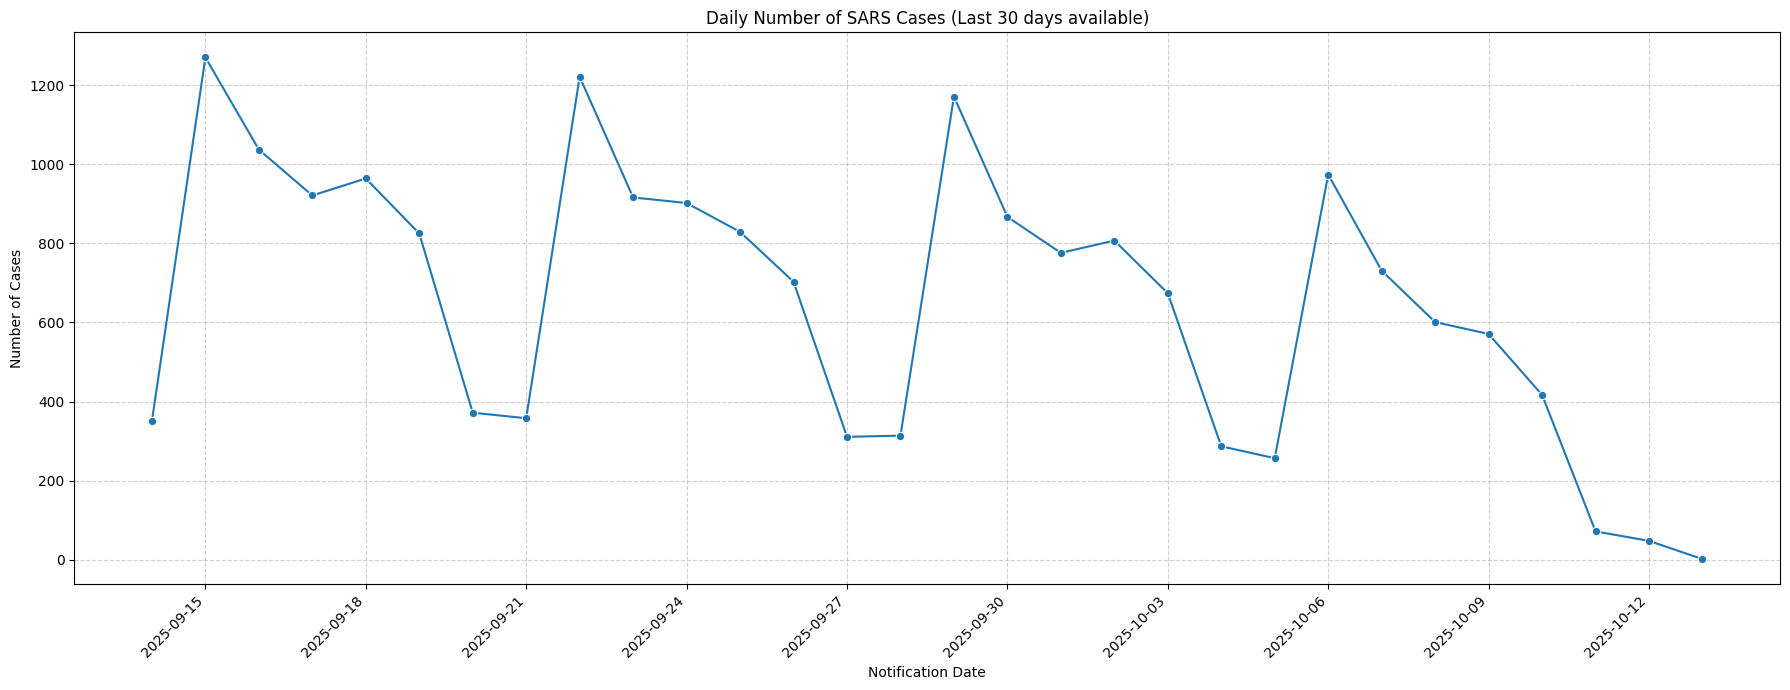

**Monthly Trend (Last 12 months)**

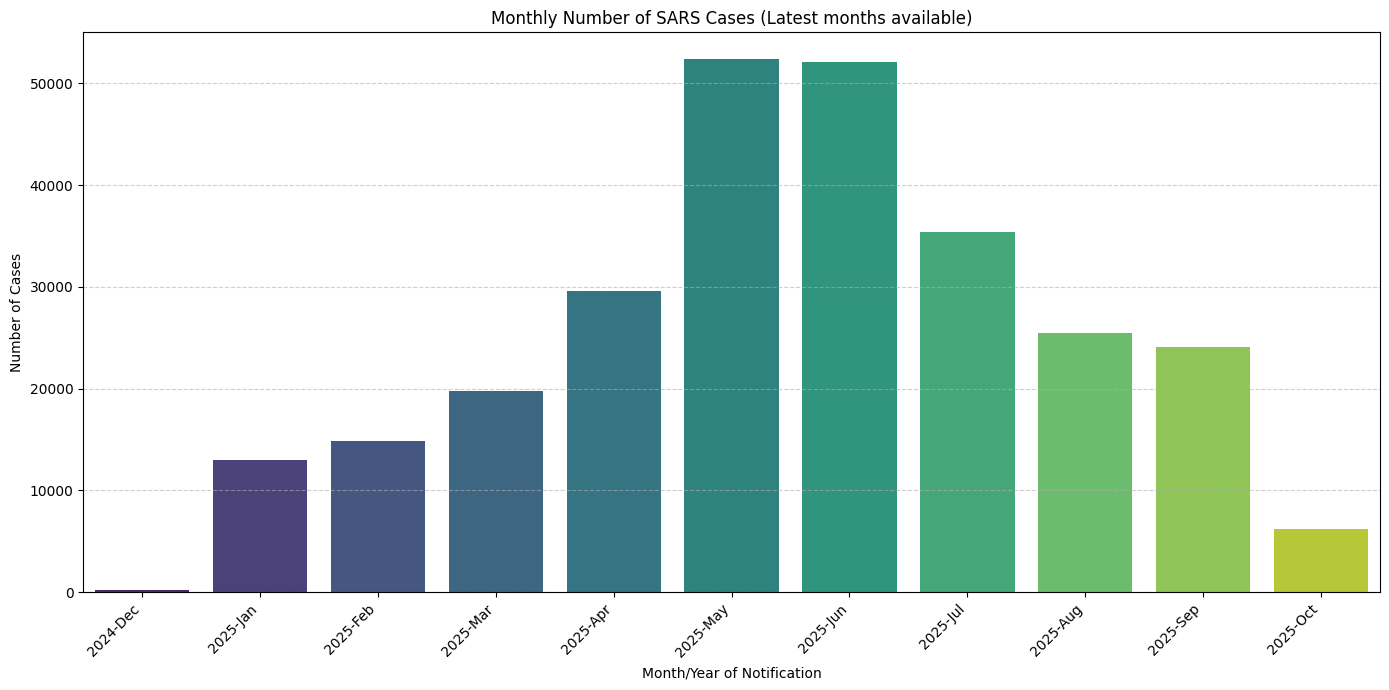

In [0]:
# --- Imports para o App ---
from IPython.display import display, HTML, clear_output, Markdown
from langchain_core.messages import SystemMessage, HumanMessage
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import pandas as pd
import os
from dotenv import load_dotenv
import html


# --- 1. Título e Botão (Virtual) ---
display(Markdown("## 🚀 Agente de Monitoramento de SRAG"))
display(Markdown("Clique no botão 'Run' (ou Ctrl+Enter) nesta célula para iniciar o pipeline completo. O processo envolve a geração de gráficos e a execução do agente de IA para gerar um relatório de monitoramento."))

# --- 2. Área de Log Dinâmico ---
log_html = "<ul>"
display_area = display(HTML(log_html + "</ul>"), display_id=True)

try:
    # --- PASSO 1: Buscando Dados para Gráficos ---
    log_html += '<li><span style="color: orange;">[...]</span> Buscando dados de tendência (Queries Spark)...</li>'
    display_area.update(HTML(log_html + "</ul>"))
    
    if 'spark' not in locals():
        raise NameError("SparkSession 'spark' não encontrado.")
    
    # (Query Diária)
    sql_daily = """
    WITH DateRange AS (SELECT MAX(data_notificacao) as max_d, MIN(data_notificacao) as min_d FROM ted_dev_desafio.indicium_health_care.srag_analysis),
    AllDays AS (SELECT explode(sequence(date_sub((SELECT max_d FROM DateRange), 29), (SELECT max_d FROM DateRange), INTERVAL 1 DAY)) AS dia_completo),
    DailyCases AS (SELECT CAST(data_notificacao AS DATE) AS dia, COUNT(*) AS contagem_casos FROM ted_dev_desafio.indicium_health_care.srag_analysis GROUP BY CAST(data_notificacao AS DATE))
    SELECT ad.dia_completo AS dia, COALESCE(dc.contagem_casos, 0) AS contagem_casos
    FROM AllDays ad LEFT JOIN DailyCases dc ON ad.dia_completo = dc.dia
    ORDER BY ad.dia_completo ASC;
    """
    # (Query Mensal)
    sql_monthly = """
    WITH MaxMonth AS (SELECT DATE_TRUNC('month', MAX(data_notificacao)) as max_m FROM ted_dev_desafio.indicium_health_care.srag_analysis),
    cte AS (SELECT DATE_TRUNC('month', data_notificacao) AS mes_ano, COUNT(*) AS contagem_casos FROM ted_dev_desafio.indicium_health_care.srag_analysis 
    WHERE DATE_TRUNC('month', data_notificacao) >= (SELECT add_months(max_m, -11) FROM MaxMonth) AND DATE_TRUNC('month', data_notificacao) <= (SELECT max_m FROM MaxMonth)
    GROUP BY mes_ano)
    SELECT * FROM cte ORDER BY mes_ano ASC;
    """
    
    # (Executando e convertendo para Pandas)
    spark_df_daily = spark.sql(sql_daily)
    spark_df_monthly = spark.sql(sql_monthly)
    df_daily = spark_df_daily.toPandas()
    df_monthly = spark_df_monthly.toPandas()
    df_daily['dia'] = pd.to_datetime(df_daily['dia'])
    df_monthly['mes_ano'] = pd.to_datetime(df_monthly['mes_ano'])

    # (Atualiza o Log)
    log_html = log_html.replace(
        '<li><span style="color: orange;">[...]</span> Buscando dados de tendência (Queries Spark)...</li>',
        '<li><span style="color: green; font-weight: bold;">[✅]</span> Dados para gráficos carregados com sucesso!</li>'
    )
    display_area.update(HTML(log_html + "</ul>"))

    # --- PASSO 2: Análise do Agente de IA ---
    log_html += '<li><span style="color: orange;">[...]</span> Inicializando o Agente de IA (Isso pode levar alguns minutos)...</li>'
    display_area.update(HTML(log_html + "</ul>"))

    # (Prompt de Síntese)
    synthesis_system_prompt = """
    You are an expert AI assistant tasked with writing a concise and informative report based *only* on the information provided in the user's message. 
    Follow the requested structure precisely. 
    Ensure the language is clear and professional, suitable for health agents.
    Combine the provided metrics, trends, and web search summaries into a coherent narrative.
    Remember to mention that graphical representations of trends were generated separately.
    """
    
    # (Prompt do Relatório Final - f-string)
    user_question_relatorio = f"""
    Generate a concise report on the current SARS scenario in Brazil, following this structure:

    1. Write a brief introduction to what SARS is and what Covid was like in Brazil.
    2. Interweave the introduction with the goal of having a report that helps health agents gain a true understanding of the severity and progression of disease outbreaks.
    3. Please note that the case analyzed for this report was 'Severe Acute Respiratory Syndrome (SARS) Database - 2019 to 2025', which is available on the OpenDataSUS website. The '2025- Live Database 10/27/2025 - CSV' file was used.

    In the body of the report, enter the metrics:

    1.  **Key Metrics (Based on the 'srag_analysis' table):**
        * {mortality_rate}
        * {brazil_mortality_rate}
        * {table_vaccine_rate}
        * {vaccine_panoram}
        * {icu_rate}
        * {brazil_icu_panoram}
        * {rate_of_sars}
        I want you to analyze the metrics.

    2.  **Recent Trends:**
        * {daily_cases}
        * {monthly_cases}
        I want you to analyze the Recent Trends.
        Please note that the graphs from this analysis (daily_cases, monthly_cases) can be viewed in the report.

    3.  **Current Context (Based on web search):**
        * What is the current mortality rate in Brazil from SARS or Covid? 
        * Use 'web_search' to find recent news about SARS in Brazil.
        * Regarding Covid-19, is there a Brazilian state that needs attention in 2025? Is it experiencing growth?
        * Generate a concise summary.
        * Please provide the source of the information at the end.

    4.  **Conclusion:**
        * Write a final paragraph combining the metrics, trends (mentioning the existence of the graphs) and the context of the news.
    """
    
    # (Invoca o Agente)
    messages_relatorio = graph.invoke({
        "messages": [
            SystemMessage(content=synthesis_system_prompt), 
            HumanMessage(content=user_question_relatorio)
        ]
    })
    
    # (Pega o resultado)
    report_text = messages_relatorio["messages"][-1].content
    
    
    # (Atualiza o Log)
    log_html = log_html.replace(
        '<li><span style="color: orange;">[...]</span> Inicializando o Agente de IA (Isso pode levar alguns minutos)...</li>',
        '<li><span style="color: green; font-weight: bold;">[✅]</span> Análise do Agente de IA concluída! Sintetizando o relatório final...</li>'
    )
    display_area.update(HTML(log_html + "</ul>"))

    # --- PASSO 3: Exibir Relatório Final E Gráficos ---
    
    # Limpa o log de status
    clear_output(wait=True) 
    
    # Exibe o título final e o relatório formatado
    display(Markdown("# 4/4 - Relatório e Resultados Finais"))
    display(Markdown("### Relatório Gerado pelo Agente"))
    display(Markdown(report_text)) # Exibe o relatório
    
    # --- GERA E EXIBE OS GRÁFICOS (ANTIGA CÉLULA 25) ---
    display(Markdown("### Trend Charts"))
    
    # (Gráfico Diário)
    if not df_daily.empty:
        display(Markdown("**Daily Trend (Last 30 days)**"))
        fig_daily, ax_daily = plt.subplots(figsize=(18, 7))
        sns.lineplot(data=df_daily, x='dia', y='contagem_casos', marker='o', ax=ax_daily)
        ax_daily.set_title('Daily Number of SARS Cases (Last 30 days available)')
        ax_daily.set_xlabel('Notification Date')
        ax_daily.set_ylabel('Number of Cases')
        ax_daily.xaxis.set_major_locator(mdates.DayLocator(interval=3))
        ax_daily.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        plt.setp(ax_daily.get_xticklabels(), rotation=45, ha='right')
        ax_daily.grid(True, linestyle='--', alpha=0.6)
        plt.tight_layout()
        display(fig_daily) # <--- EXIBE A FIGURA
        plt.close(fig_daily) # Fecha para não duplicar
    else:
        display(Markdown("*Daily data unavailable for plotting.*"))

    # (Gráfico Mensal)
    if not df_monthly.empty:
        display(Markdown("**Monthly Trend (Last 12 months)**"))
        fig_monthly, ax_monthly = plt.subplots(figsize=(14, 7))
        # [Correção do Warning]
        sns.barplot(data=df_monthly, x='mes_ano', y='contagem_casos', palette='viridis', ax=ax_monthly, hue='mes_ano', legend=False)
        ax_monthly.set_title('Monthly Number of SARS Cases (Latest months available)')
        ax_monthly.set_xlabel('Month/Year of Notification')
        ax_monthly.set_ylabel('Number of Cases')
        labels = df_monthly['mes_ano'].dt.strftime('%Y-%b')
        ax_monthly.set_xticks(range(len(labels)))
        ax_monthly.set_xticklabels(labels, rotation=45, ha='right')
        ax_monthly.grid(axis='y', linestyle='--', alpha=0.6)
        plt.tight_layout()
        display(fig_monthly) # <--- EXIBE A FIGURA
        plt.close(fig_monthly) # Fecha para não duplicar
    else:
        display(Markdown("*Monthly data unavailable for plotting.*"))

    # --- PASSO 4: Exibir Auditoria ---
    
    # Pega o conteúdo de auditoria
    audit_text = str(messages_relatorio) 
    
    # Escapa caracteres HTML para exibição segura dentro do <pre>
    escaped_audit_text = html.escape(audit_text)

    # Cria o menu "sanfona" (accordion)
    audit_html = f"""
    <details style="margin-top: 20px; border: 1px solid #ccc; border-radius: 5px;">
        <summary style="padding: 10px; font-weight: bold; cursor: pointer; background-color: #f5f5f5;">
            Clique para ver a trajetória completa (Auditoria/Debug)
        </summary>
        <pre style="padding: 10px; background-color: #fafafa; border-top: 1px solid #ccc; overflow-x: auto; white-space: pre-wrap; word-wrap: break-word;">
{escaped_audit_text}
        </pre>
    </details>
    """
    
    display(HTML(audit_html))

except Exception as e:
    # Tratamento de Erro
    clear_output(wait=True)
    error_message = f"""
    <div style="border: 2px solid red; padding: 10px; background-color: #fff0f0;">
        <h3 style="color: red;">❌ Erro no Pipeline</h3>
        <p>Ocorreu um erro durante a execução:</p>
        <pre>{e}</pre>
    </div>
    """
    display(HTML(error_message))